In [72]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [73]:
import numpy as np
import pandas as pd
import datetime as dt

Reflect tables into SQLchemy ORM

In [74]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [75]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [76]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [77]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [78]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [79]:
# Create our session (link) from Python to the DB
session = Session(engine)

Exploratory precipitation analysis

In [80]:
# Find the most recent date in the data set.
most_recent_date = pd.read_sql_query('SELECT MAX(date) FROM measurement', engine) 
print(most_recent_date)

    MAX(date)
0  2017-08-23


In [81]:
# Using that date, get the previous 12 months of precipitation data by querying the previous 12 months of data.
previous_12_months = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("previous 12 months: {}".format(previous_12_months))

previous 12 months: 2016-08-23


In [82]:
# Perform a query to retrieve the data and precipitation scores

scores = session.query(measurement.date,
                       measurement.prcp).filter(measurement.date>previous_12_months).\
                        order_by(measurement.date).all()
scores[0:10]

[('2016-08-24', 0.08),
 ('2016-08-24', 2.15),
 ('2016-08-24', 2.28),
 ('2016-08-24', None),
 ('2016-08-24', 1.22),
 ('2016-08-24', 2.15),
 ('2016-08-24', 1.45),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.0)]

In [83]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
scores_pd = pd.DataFrame(scores)
scores_pd = scores_pd.set_index('date')
scores_pd = scores_pd.sort_index()
scores_pd.head

<bound method NDFrame.head of             prcp
date            
2016-08-24  0.08
2016-08-24  2.15
2016-08-24  2.28
2016-08-24   NaN
2016-08-24  1.22
...          ...
2017-08-22  0.50
2017-08-23  0.00
2017-08-23  0.00
2017-08-23  0.08
2017-08-23  0.45

[2223 rows x 1 columns]>

ConversionError: Failed to convert value(s) to axis units: 'inches'

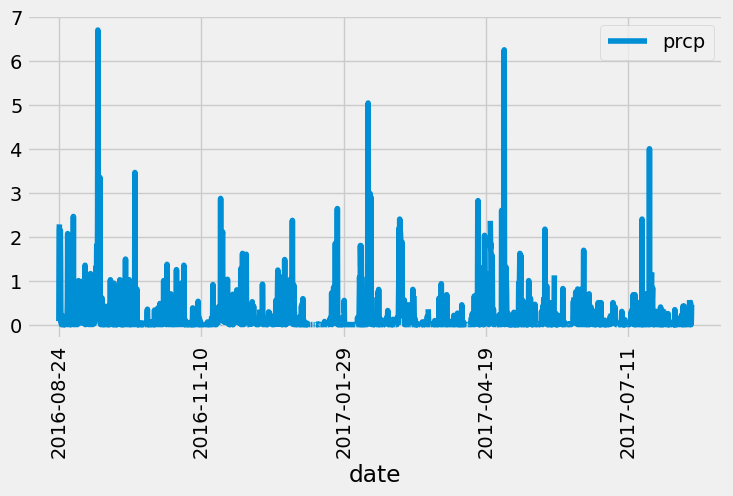

In [84]:
# Use Pandas to calculate the summary statistics for the precipitation data
scores_pd.plot(figsize=(8,4))
plt.xticks(rotation='vertical')
plt.yticks('inches')
plt.title('Precipitation')

plt.show()

In [85]:
# Use Pandas to calculate the summary statistics for the precipitation data

scores_pd  .describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


Exploratory Station Analysis

In [86]:
# Design a query to calculate the total number of stations in the dataset

available_st = session.query(measurement.station).distinct().count()
available_st

9

In [87]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_st = session.query(measurement.station,func.count(measurement.station)).\
group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
active_st

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [88]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp = session.query(func.min(measurement.tobs),
                     func.max(measurement.tobs),
func.avg(measurement.tobs)).filter(measurement.station==active_st[0][0]).all()
print('Lowest temperature: {}.\nHighest temperature: {}\nAverage temperature: {}'.\ 
      format(temp[0][0], (temp[0][2],2)))


SyntaxError: unexpected character after line continuation character (540362600.py, line 5)

In [89]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_station = session.query(measurement.station, func.count(measurement.tobs)).group_by(measurement.station).\
order_by(func.count(measurement.station).desc()).first()
most_tempt=most_station[0]


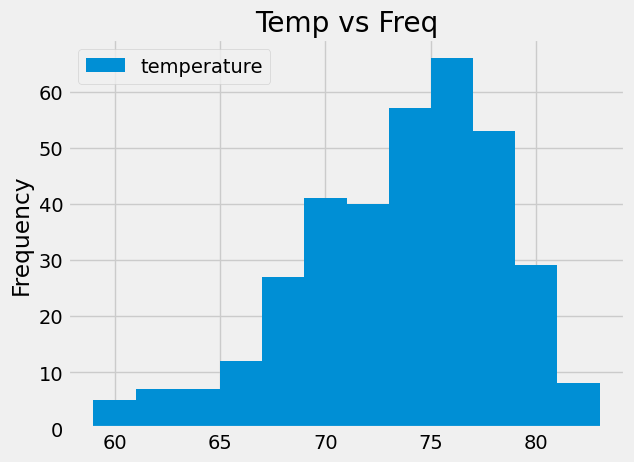

In [90]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
observe = session.query(measurement.tobs).filter(measurement.date>=previous_12_months).\
filter(measurement.station==most_tempt).all()
observe_pd = pd.DataFrame(observe,columns=['temperature'])

observe_pd.plot.hist(bins=12,title='Temp vs Freq')
plt.show()

Close Session

In [91]:
# Close Session
session.close()